### Intro

In this notebook, I go a step further with the data and feed it into a win probability model based on Brownian Motion. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from nba_win_probability import dataloader, transformations, plotting, win_probability

In [3]:
df = dataloader.load_season("2018")
transformed_df = transformations.transform_data_for_analysis(df)
transformed_df = transformed_df[['GAME_ID', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER2_TEAM_ABBREVIATION',  'PERIOD', 'SCORE', 'SCOREMARGIN', 'SEASON', 'QUARTER_TS', 'TIME_ELAPSED', 'MINUTE', 'SCORE_BY_MINUTE']]
transformed_df.head(5)

,GAME_ID,PLAYER1_TEAM_ABBREVIATION,PLAYER2_TEAM_ABBREVIATION,PERIOD,SCORE,SCOREMARGIN,SEASON,QUARTER_TS,TIME_ELAPSED,MINUTE,SCORE_BY_MINUTE
0,21800001,BOS,PHI,1,NaN,0.0,2018,0.000000,0.000000,0.0,0.0
1,21800001,PHI,PHI,1,2 - 0,-2.0,2018,1.083333,1.083333,1.0,-2.0
2,21800001,BOS,BOS,1,2 - 2,0.0,2018,2.683333,2.683333,2.0,2.0
3,21800001,PHI,BOS,1,6 - 4,-2.0,2018,3.750000,3.750000,3.0,-2.0
4,21800001,BOS,BOS,1,8 - 7,-1.0,2018,4.566667,4.566667,4.0,1.0


In [4]:
# Use the minute-by-minute scoring as the parameter for the simulation model
scores_by_minute = transformed_df['SCORE_BY_MINUTE']
bwp = win_probability.BrownianWinProbabilitySimulation(scores_by_minute, seed=808)

In [5]:
# Estimate the win probability with a 7 pt. lead and 20 minutes remaining.
score_diff = 7
time_remaining = 20
outcome = bwp.estimate_home_win_probability(score_diff, time_remaining, num_simulations=7)
print(outcome.estimated_win_probability)

0.8571428571428571


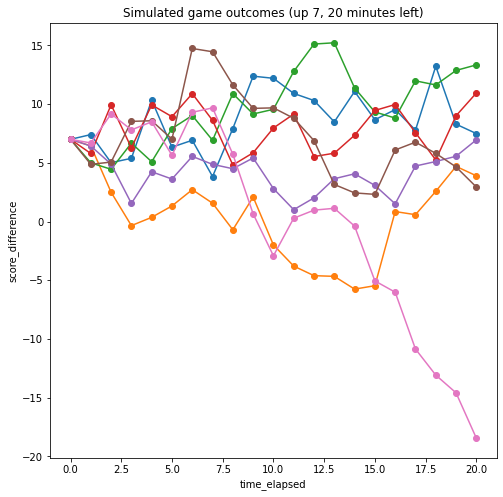

In [6]:
replications = outcome.replications
plt.figure(figsize=(8, 8))
plt.title('Simulated game outcomes (up 7, 20 minutes left)')
plt.xlabel('time_elapsed')
plt.ylabel('score_difference')
for rep in replications:
    plt.plot([*range(0, len(rep), 1)], rep, '-o')

The plot above shows a series of simulated outcomes for a game where the home team is up by 7 with 20 minutes left.

In [7]:
times_remaining = [35, 25, 15, 5]
score_differences = list(range(-20, 21))
data = []

for time_remaining in times_remaining:
    for score_diff in score_differences:
        for i in range(5):
            estimate = bwp.estimate_home_win_probability(score_diff, time_remaining, 1000).estimated_win_probability
            data.append({'PROBA': estimate, 'TIME_REMAINING': time_remaining, 'SCOREMARGIN': score_diff})
df = pd.DataFrame(data)

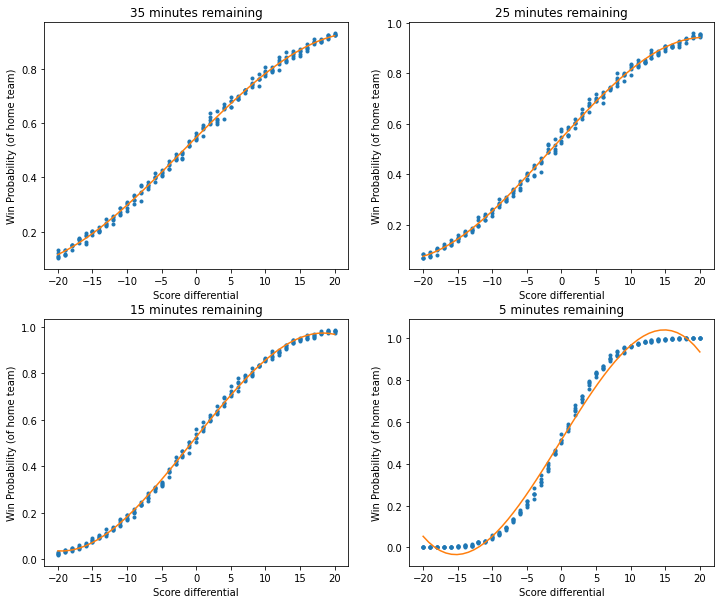

In [8]:
figs, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_map = {35: axs[0, 0], 25: axs[0, 1], 15: axs[1, 0], 5: axs[1, 1]}
for i in times_remaining:
    d = df[df['TIME_REMAINING'] == i]
    x = d['SCOREMARGIN']
    y = d['PROBA']
    
    p = np.poly1d(np.polyfit(x, y, 3))
    t = np.linspace(-20, 20)
    
    plot_map[i].plot(x, y, '.')
    plot_map[i].plot(t, p(t), '-')
    plot_map[i].set_title(f"{i} minutes remaining")
    
for ax in axs.flat:
    ax.set(xlabel='Score differential', ylabel='Win Probability (of home team)')

This plot displays how score differential impacts win probability at different points in the game. 